In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn

from einops import rearrange

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr

from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
btc_file = '../Bitcoin_data/all_together.csv'
# btc_file = '../knn/Bitcoin_01.10.2017-20.03.2025_historical_data_coinmarketcap.csv'

df_btc = pd.read_csv(btc_file, sep=';')

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

scaled_df = df_btc.copy()

In [3]:
columns_to_drop = ['timeOpen', 'timeClose', 'timeHigh', 'timeLow']
for col in columns_to_drop:
    if col in scaled_df.columns:
        scaled_df.drop(columns=[col], inplace=True)

if 'timestamp' in scaled_df.columns:
    scaled_df = scaled_df.set_index('timestamp')

feature_columns = ['open', 'high', 'low', 'volume', 'marketCap']
target_column = 'close'

available_feature_cols = [col for col in feature_columns if col in scaled_df.columns]
print(f"Доступні колонки для features: {available_feature_cols}")

if target_column not in scaled_df.columns:
    print(f"Помилка: колонка '{target_column}' не знайдена!")
    exit()

scaled_df[available_feature_cols] = feature_scaler.fit_transform(scaled_df[available_feature_cols])
scaled_df[[target_column]] = target_scaler.fit_transform(scaled_df[[target_column]])

print("Структура даних:")
print(scaled_df.head())
print(f"Shape: {scaled_df.shape}")

Доступні колонки для features: ['open', 'high', 'low', 'volume', 'marketCap']
Структура даних:
                          name      open      high       low     close  \
timestamp                                                                
2014-04-09T23:59:59.999Z  2781  0.003718  0.003641  0.003699  0.003600   
2014-04-08T23:59:59.999Z  2781  0.003668  0.003656  0.003737  0.003693   
2014-04-07T23:59:59.999Z  2781  0.003792  0.003702  0.003728  0.003660   
2014-04-06T23:59:59.999Z  2781  0.003809  0.003736  0.003800  0.003760   
2014-04-05T23:59:59.999Z  2781  0.003660  0.003711  0.003720  0.003772   

                            volume  marketCap  
timestamp                                      
2014-04-09T23:59:59.999Z  0.000038   0.002320  
2014-04-08T23:59:59.999Z  0.000031   0.002378  
2014-04-07T23:59:59.999Z  0.000044   0.002356  
2014-04-06T23:59:59.999Z  0.000029   0.002419  
2014-04-05T23:59:59.999Z  0.000038   0.002426  
Shape: (4399, 7)


In [4]:
def prepare_data(df, window_size=5):
    X, y = [], []
    feature_cols = [col for col in df.columns if col != 'close']
    
    for i in range(len(df) - window_size):
        features = df[feature_cols].iloc[i:i+window_size].values
        target = df['close'].iloc[i+window_size]
        
        X.append(features.flatten())
        y.append(target)
    
    return np.array(X), np.array(y)


In [5]:
class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, dropout=dropout, batch_first=True)

    def forward(self, x):
        out, _ = self.attn(x, x, x)
        return out

class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        self.attn = ProbSparseSelfAttention(d_model, n_heads, dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x

class InformerModel(nn.Module):
    def __init__(self, input_size, d_model=64, n_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        self.encoder = nn.Sequential(
            *[EncoderLayer(d_model, n_heads, dropout) for _ in range(num_layers)]
        )
        self.projection = nn.Linear(d_model, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)
        x = self.embedding(x) 
        x = self.encoder(x)
        x = x[:, -1, :]        
        return self.projection(x)  


In [6]:
def run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                             target_scaler, results_dict, epochs=100, lr=0.001,
                             early_stopping_threshold=0.1, patience=10):
    print(f"Training {model_name}...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

    model = model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    best_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        train_loss = loss.item()
        train_losses.append(train_loss)

        if train_loss < early_stopping_threshold:
            print(f"Early stopping at epoch {epoch+1} (loss {train_loss:.6f} < {early_stopping_threshold})")
            break

        if train_loss < best_loss - 1e-5:
            best_loss = train_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.6f}")

    model.eval()
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy()

    preds_inv = target_scaler.inverse_transform(preds)
    y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
    mae = mean_absolute_error(y_test_inv, preds_inv)

    results_dict[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'final_loss': train_losses[-1],
        'model': model,  
        'X_test': X_test,
        'y_test': y_test
    }

    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print("-" * 50)

    return model


In [7]:
results = {}

window_sizes = [5, 10, 15]
hidden_sizes = [(64,), (128,), (64, 32), (128, 64), (256, 128)]
learning_rates = [0.001, 0.01]
epochs_list = [50, 100, 1000]

best_X_test, best_y_test = None, None

print("Початок експериментів з MLP моделями")
print("=" * 60)

experiment_count = 0
total_experiments = len(window_sizes) * len(hidden_sizes) * len(learning_rates) * len(epochs_list)


Початок експериментів з MLP моделями


In [8]:
for window_size in window_sizes:
    print(f"\n Window size: {window_size}")
    
    X, y = prepare_data(scaled_df, window_size=window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    
    best_X_test, best_y_test = X_test, y_test
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    input_size = X_train.shape[1]
    
    for hidden_config in hidden_sizes:
        for lr in learning_rates:
            for epochs in epochs_list:
                experiment_count += 1

                model = InformerModel(input_size=input_size)
                model_name = f"Informer_w{window_size}_h{hidden_config}_lr{lr}_e{epochs}"
                print(f"\n[{experiment_count}/{total_experiments}] {model_name}")


                
                run_torch_model_with_save(model_name, model, X_train, y_train, X_test, y_test, 
                          target_scaler, results,
                          epochs=epochs, lr=lr,
                          early_stopping_threshold=0.1, patience=10)

print("\n" + "=" * 80)
print(" ПІДСУМОК РЕЗУЛЬТАТІВ ВСІХ ЕКСПЕРИМЕНТІВ")
print("=" * 80)



 Window size: 5
Training set shape: (3515, 30)
Test set shape: (879, 30)

[1/90] Informer_w5_h(64,)_lr0.001_e50
Training Informer_w5_h(64,)_lr0.001_e50...
Early stopping at epoch 2 (loss 0.059208 < 0.1)
RMSE: 72713.4407, MAE: 68022.4332
--------------------------------------------------

[2/90] Informer_w5_h(64,)_lr0.001_e100
Training Informer_w5_h(64,)_lr0.001_e100...
Early stopping at epoch 5 (loss 0.076063 < 0.1)
RMSE: 52036.7351, MAE: 45192.7856
--------------------------------------------------

[3/90] Informer_w5_h(64,)_lr0.001_e1000
Training Informer_w5_h(64,)_lr0.001_e1000...
Early stopping at epoch 2 (loss 0.050434 < 0.1)
RMSE: 27014.6997, MAE: 23401.0409
--------------------------------------------------

[4/90] Informer_w5_h(64,)_lr0.01_e50
Training Informer_w5_h(64,)_lr0.01_e50...
Early stopping at epoch 6 (loss 0.012443 < 0.1)
RMSE: 111226.6638, MAE: 108199.8543
--------------------------------------------------

[5/90] Informer_w5_h(64,)_lr0.01_e100
Training Informer_w5_

In [9]:
sorted_results = sorted(results.items(), key=lambda x: x[1]['RMSE'])

print(f"{'Model Name':<40} {'RMSE':<10} {'MAE':<10} {'Final Loss':<12}")
print("-" * 80)

for model_name, metrics in sorted_results:
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    final_loss = metrics['final_loss']
    print(f"{model_name:<40} {rmse:<10.4f} {mae:<10.4f} {final_loss:<12.6f}")

best_model = sorted_results[0]
print(f"\n НАЙКРАЩА МОДЕЛЬ: {best_model[0]}")
print(f"   RMSE: {best_model[1]['RMSE']:.4f}")
print(f"   MAE: {best_model[1]['MAE']:.4f}")

print(f"\n АНАЛІЗ ПО WINDOW SIZE:")
for ws in window_sizes:
    ws_results = [(name, metrics) for name, metrics in results.items() if f"_w{ws}_" in name]
    if ws_results:
        best_ws = min(ws_results, key=lambda x: x[1]['RMSE'])
        avg_rmse = np.mean([metrics['RMSE'] for _, metrics in ws_results])
        print(f"Window {ws}: Найкращий RMSE = {best_ws[1]['RMSE']:.4f}, Середній RMSE = {avg_rmse:.4f}")

Model Name                               RMSE       MAE        Final Loss  
--------------------------------------------------------------------------------
Informer_w10_h(128,)_lr0.001_e50         16560.1142 13451.8411 0.014151    
Informer_w5_h(256, 128)_lr0.001_e1000    25154.5432 21786.8025 0.049584    
Informer_w5_h(256, 128)_lr0.001_e100     25645.4975 22175.6255 0.062049    
Informer_w15_h(256, 128)_lr0.01_e1000    25877.7865 22426.7156 0.037445    
Informer_w15_h(128, 64)_lr0.01_e100      26218.9715 22704.7684 0.023948    
Informer_w15_h(128,)_lr0.01_e100         26873.4115 22458.7867 0.018628    
Informer_w5_h(64,)_lr0.001_e1000         27014.6997 23401.0409 0.050434    
Informer_w10_h(128,)_lr0.01_e1000        27794.1044 24099.0030 0.078720    
Informer_w5_h(64,)_lr0.01_e1000          27875.8839 24778.7662 0.056854    
Informer_w10_h(64,)_lr0.001_e50          28028.4596 24316.4193 0.017593    
Informer_w15_h(64, 32)_lr0.01_e1000      31610.6692 24188.5147 0.010867    
Informe

--------------------
ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ
--------------------
 ПОЧАТОК ПОВНОГО АНАЛІЗУ МОДЕЛІ
 АНАЛІЗ КОРЕЛЯЦІЇ ОЗНАК (ПІРСОН)


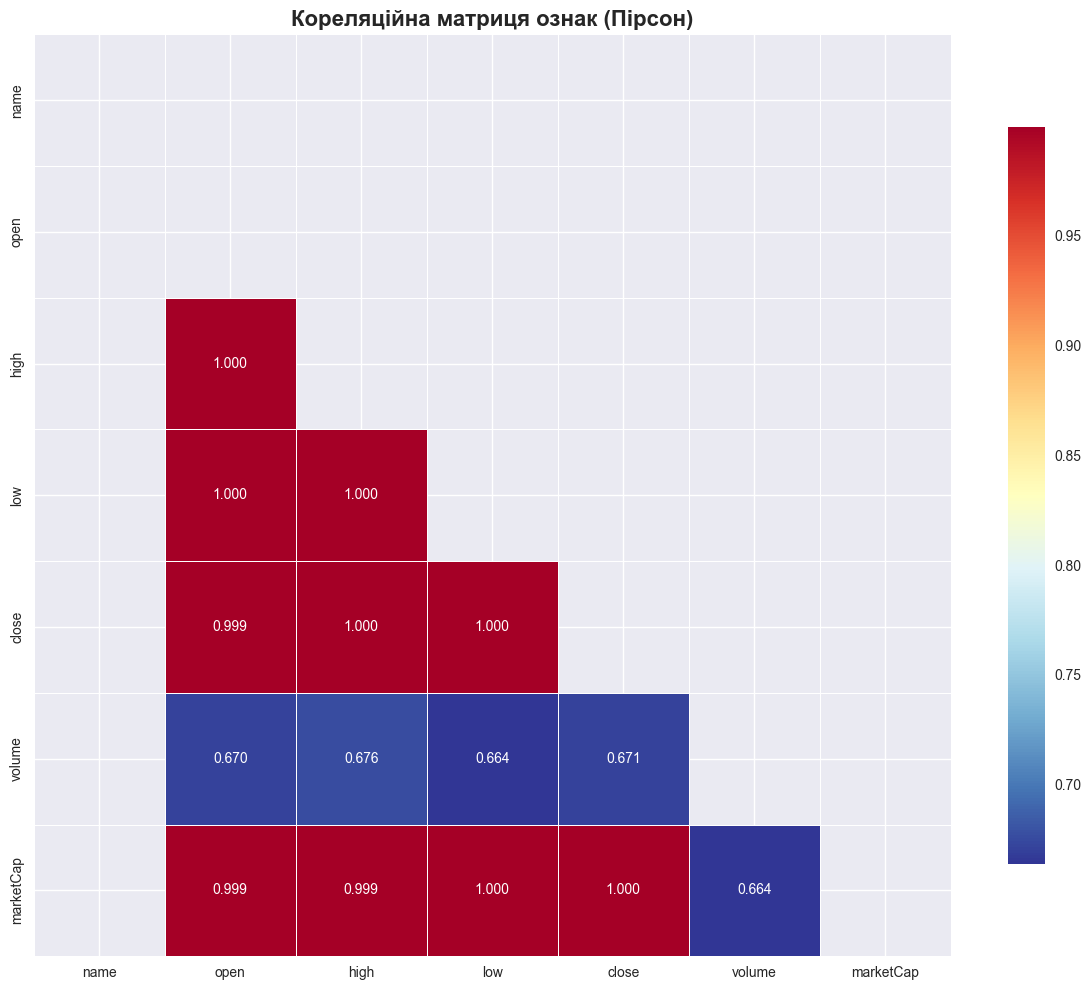


 Найсильніші кореляції:
 1. high         ↔ close       :  1.000
 2. close        ↔ marketCap   :  1.000
 3. open         ↔ high        :  1.000
 4. low          ↔ close       :  1.000
 5. open         ↔ low         :  1.000
 6. low          ↔ marketCap   :  1.000
 7. high         ↔ low         :  1.000
 8. high         ↔ marketCap   :  0.999
 9. open         ↔ close       :  0.999
10. open         ↔ marketCap   :  0.999

 РОЗПОДІЛ ОЗНАК


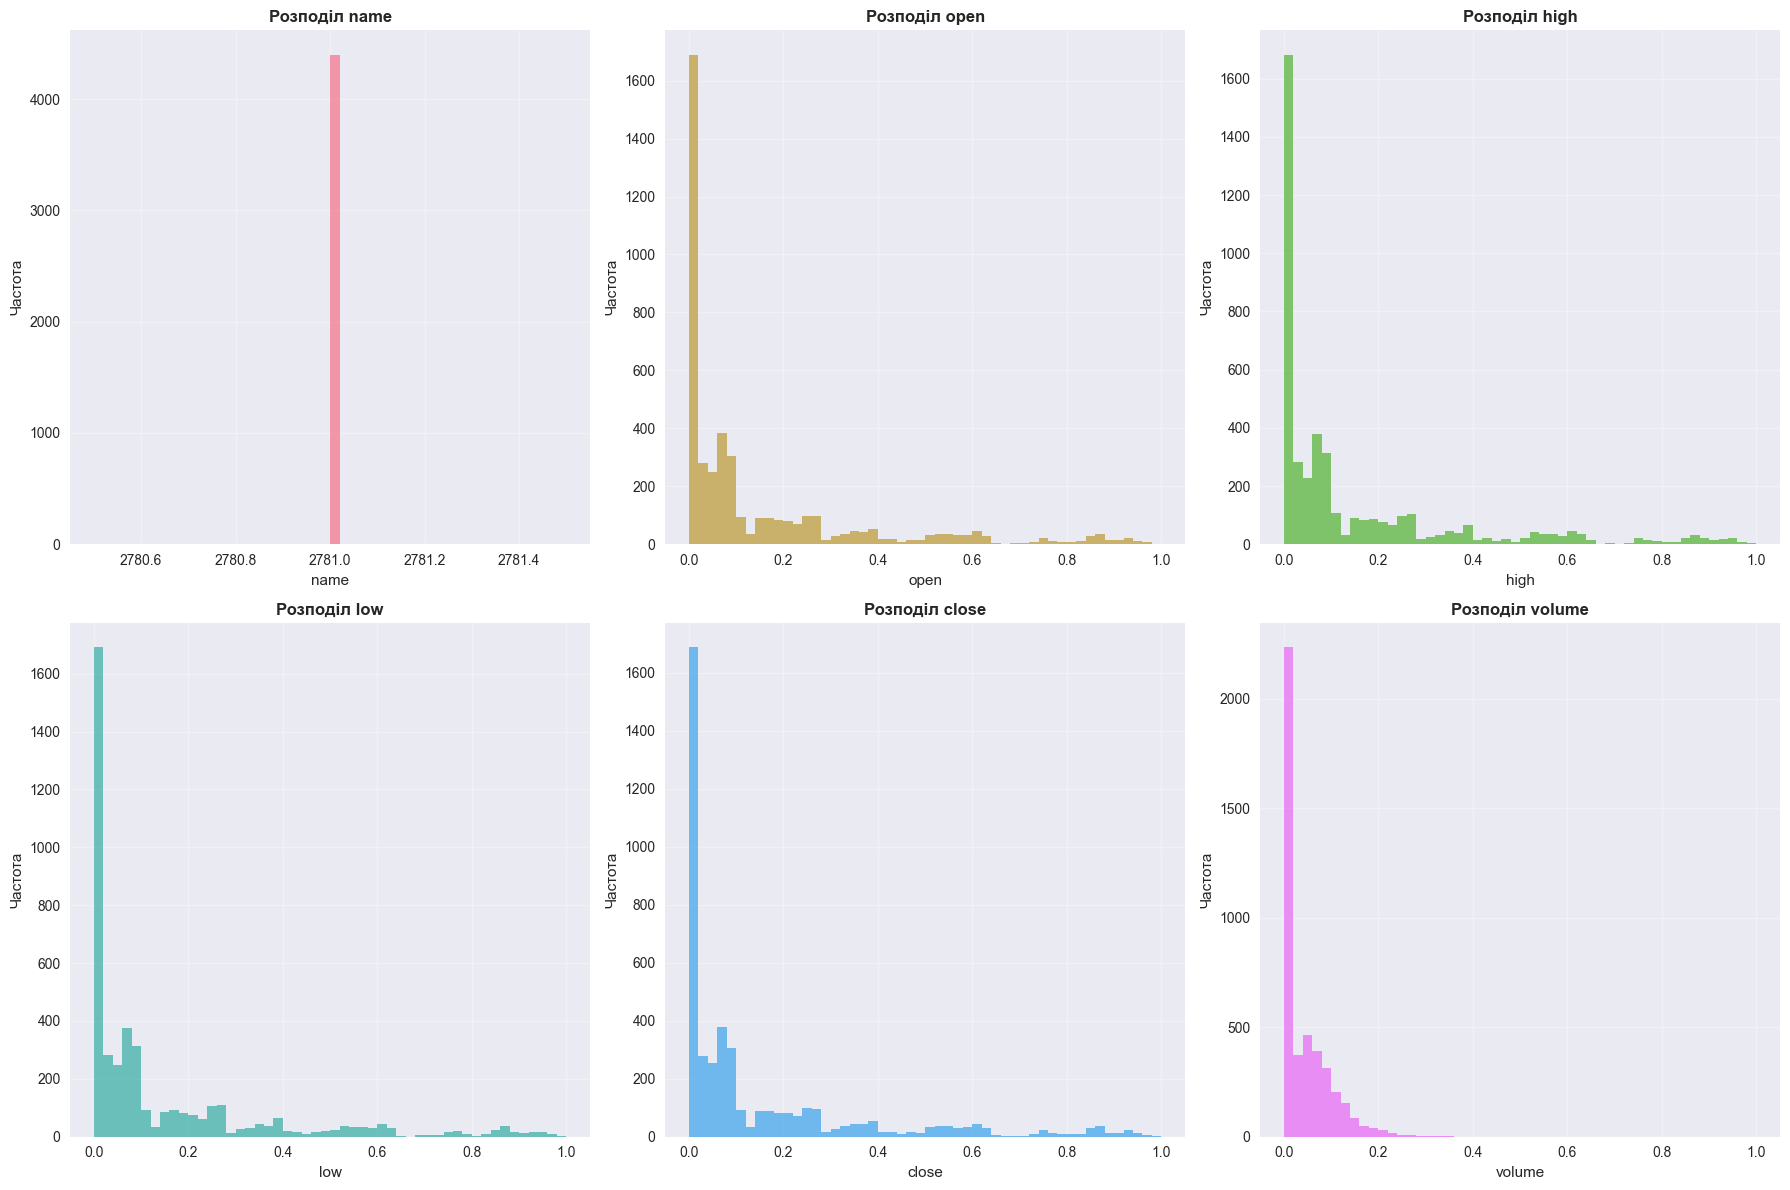


 ДЕТАЛЬНИЙ АНАЛІЗ НАЙКРАЩОЇ МОДЕЛІ: Informer_w10_h(128,)_lr0.001_e50
 МЕТРИКИ РЕГРЕСІЇ:
RMSE (Root Mean Square Error): 16560.1142
MAE (Mean Absolute Error): 13451.8411
MAPE (Mean Absolute Percentage Error): 25.56%
R² Score: 0.5873
Explained Variance Score: 0.6428


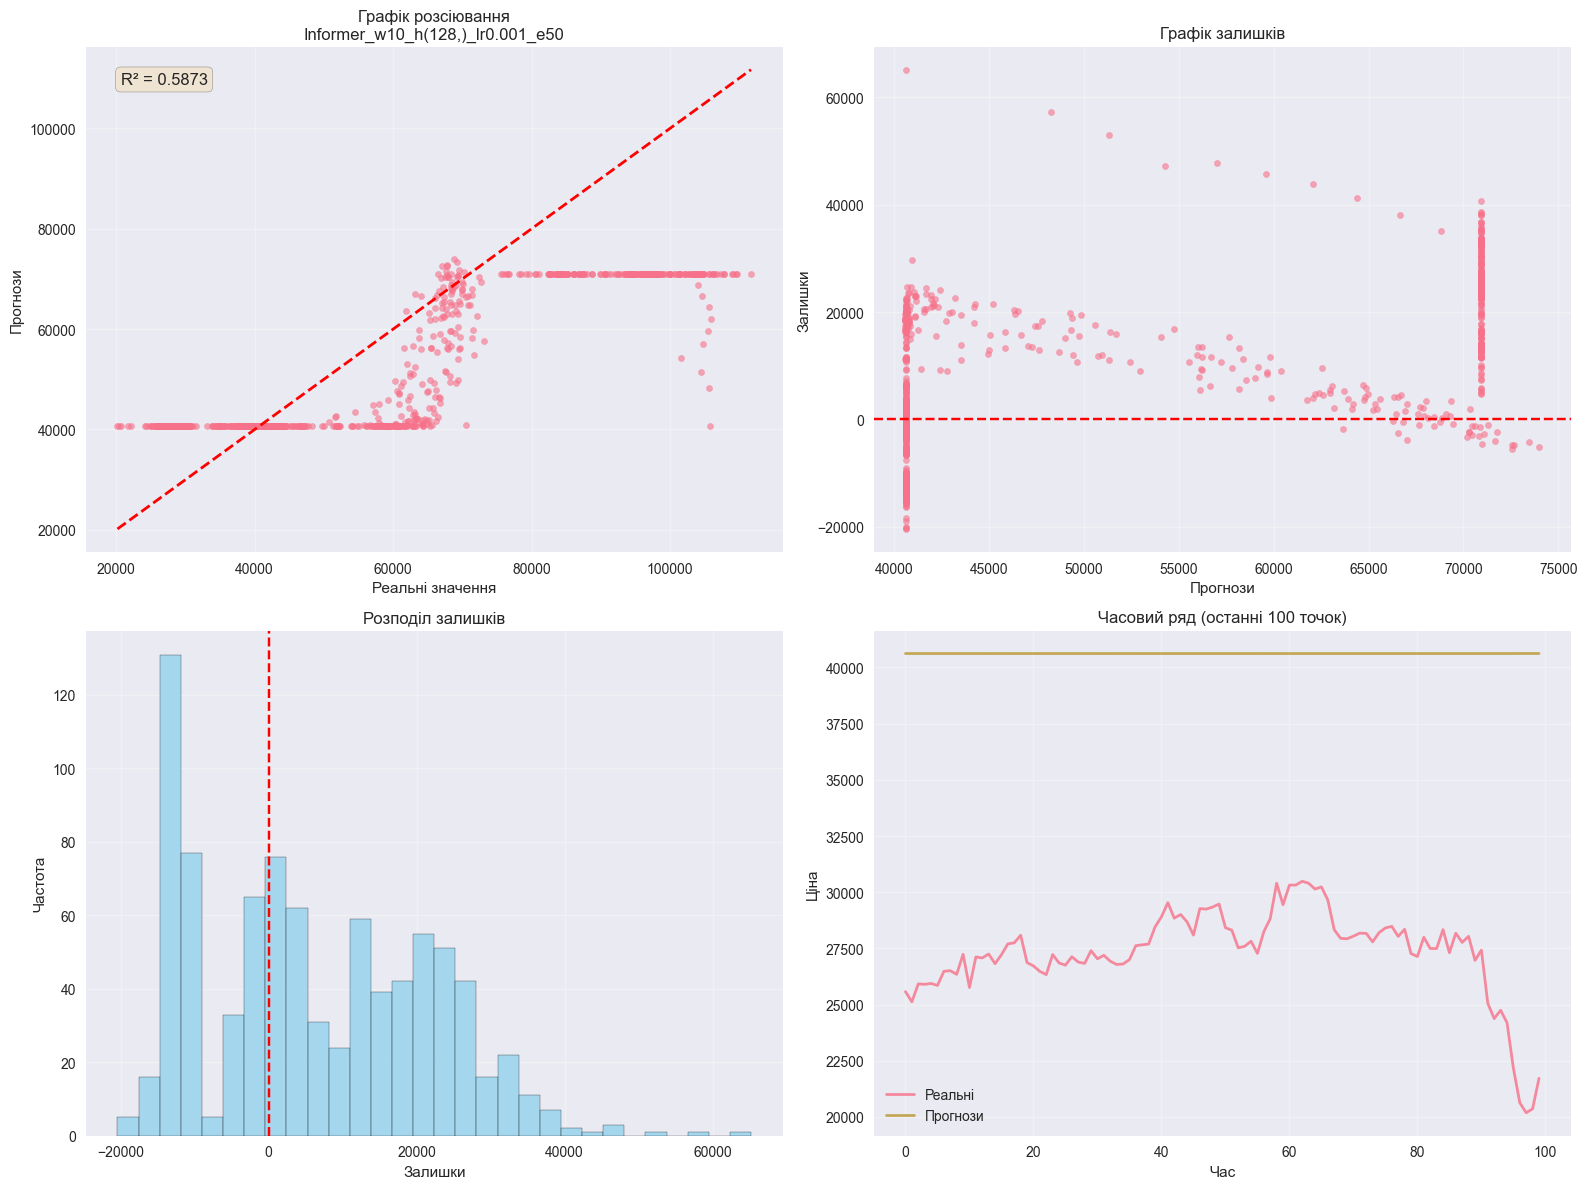


 КЛАСИФІКАЦІЙНІ МЕТРИКИ (Напрямок руху ціни):
Класи: 0 = Спадання, 1 = Зростання
Accuracy: 0.5234
Precision: 0.5229
Recall: 0.5234
F1-Score: 0.5226

 Детальний класифікаційний звіт:
              precision    recall  f1-score   support

    Спадання       0.53      0.56      0.55       446
   Зростання       0.52      0.48      0.50       431

    accuracy                           0.52       877
   macro avg       0.52      0.52      0.52       877
weighted avg       0.52      0.52      0.52       877



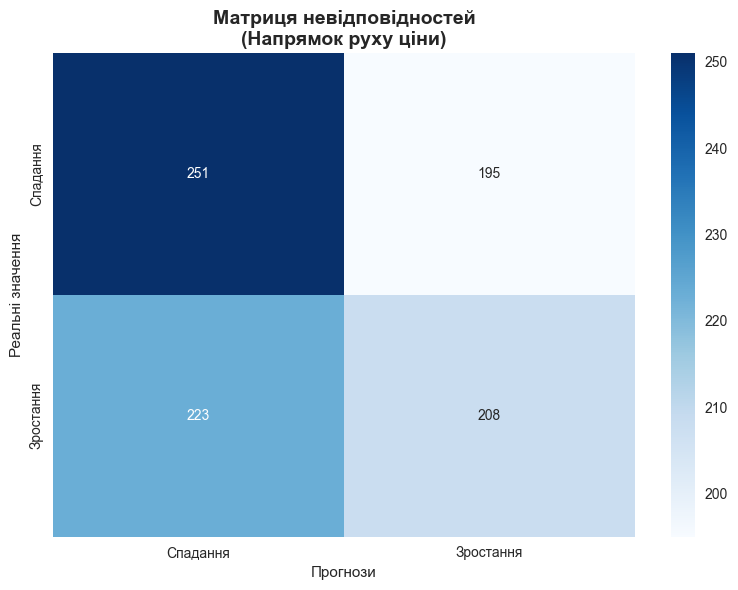


 Інтерпретація матриці невідповідностей:
True Negatives (правильно передбачені спадання): 251
False Positives (помилково передбачені зростання): 195
False Negatives (пропущені зростання): 223
True Positives (правильно передбачені зростання): 208

 ТАБЛИЦЯ ПОРІВНЯННЯ МЕТРИК:
Метрика      Значення   Опис                                    
-----------------------------------------------------------------
Accuracy     0.5234     Частка правильних прогнозів             
Precision    0.5229     Частка правильних позитивних прогнозів  
Recall       0.5234     Частка знайдених позитивних випадків    
F1-Score     0.5226     Гармонічне середнє Precision і Recall   


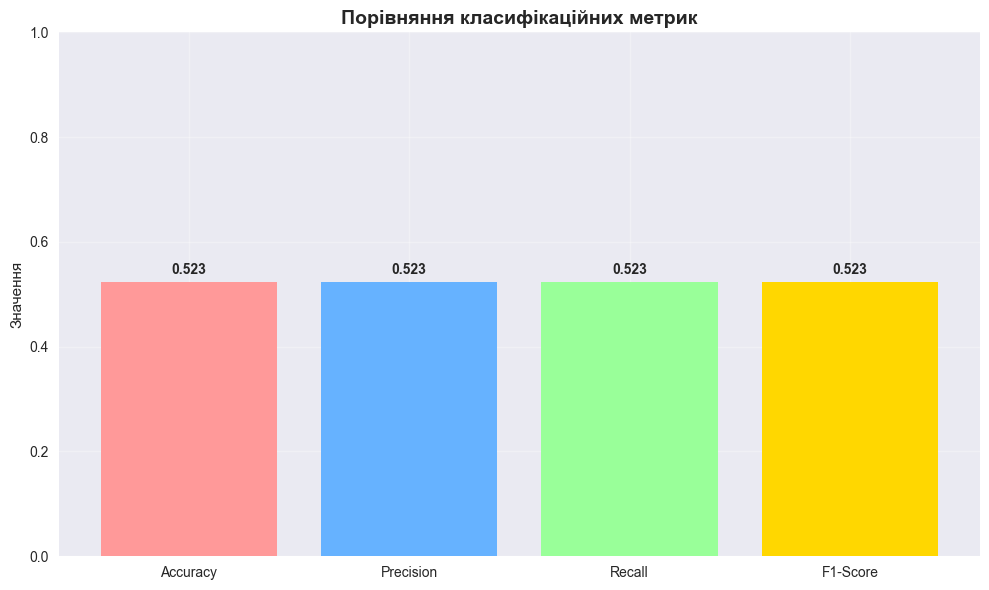


 АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК
 Статистика параметрів моделі:
Загальна кількість параметрів: 50,625
Навчальні параметри: 50,625

 Статистика вхідних ознак:
       Feature       Mean     Std        Min        Max
0    Feature_0  2781.0000  0.0000  2781.0000  2781.0000
1    Feature_1     0.5101  0.2290     0.2247     1.0000
2    Feature_2     0.5184  0.2330     0.2295     1.0000
3    Feature_3     0.5116  0.2293     0.2266     1.0000
4    Feature_4     0.0874  0.0582     0.0152     0.4252
5    Feature_5     0.5055  0.2316     0.2195     1.0000
6    Feature_6  2781.0000  0.0000  2781.0000  2781.0000
7    Feature_7     0.5100  0.2291     0.2241     1.0000
8    Feature_8     0.5183  0.2330     0.2295     1.0000
9    Feature_9     0.5115  0.2294     0.2266     1.0000
10  Feature_10     0.0874  0.0581     0.0152     0.4252
11  Feature_11     0.5055  0.2316     0.2195     1.0000
12  Feature_12  2781.0000  0.0000  2781.0000  2781.0000
13  Feature_13     0.5099  0.2292     0.2180     1.0000
14  Featu

In [10]:
print("-" * 20)
print("ПОЧАТОК ДЕТАЛЬНОГО АНАЛІЗУ НАЙКРАЩОЇ МОДЕЛІ")
print("-" * 20)

best_model_name = sorted_results[0][0]

from ModelAnalyzer import ModelAnalyzer, run_complete_analysis

best_model_name = best_model[0]
model_results = best_model[1]
actual_pytorch_model = model_results['model']

test_data_X = model_results['X_test']
test_data_y = model_results['y_test']

analyzer, analysis_results = run_complete_analysis(
    df=scaled_df,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler,
    best_model=actual_pytorch_model,
    X_test=test_data_X,
    y_test=test_data_y,
    model_name=best_model_name
)